In [1]:
import os
from pathlib import Path
import datetime
import json

import ee
from cropharvest.datasets import CropHarvest, CropHarvestLabels
import geemap
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [2]:
## Make sure you're using an environment with geemap
import sys
print('environment:',  sys.executable.split('/')[-3])

environment: nigeria-crop-mask-gpu3


## Togo and brazil labels

In [3]:
DATA_DIR = "../data/cropharvest"

In [4]:
# This will download all geowiki data
evaluation_datasets = CropHarvest.create_benchmark_datasets(DATA_DIR)

In [5]:
evaluation_datasets

[CropHarvestEval(Kenya_1_maize, Kenya_maize),
 CropHarvestEval(Brazil_0_coffee, Brazil_coffee),
 CropHarvestEval(Togo_crop, togo-eval)]

In [6]:
cropharvest_labels = CropHarvestLabels(DATA_DIR)
cropharvest_df = cropharvest_labels.as_geojson()
cropharvest_df

,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry
0,None,None,None,None,0,1,10.712596,37.083128,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08252 10.71274, 37.08348 10.71291..."
1,None,None,None,None,1,1,10.724197,37.087377,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08721 10.72398, 37.08714 10.72429..."
2,None,None,None,None,2,1,10.713894,37.085091,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08498 10.71371, 37.08481 10.71393..."
3,None,None,None,None,3,1,10.713338,37.090290,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.09021 10.71320, 37.09014 10.71341..."
4,None,None,None,None,4,1,10.721858,37.083121,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08307 10.72160, 37.08281 10.72197..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95181,None,None,None,None,2395,0,-2.256238,28.550432,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (28.55043 -2.25624)
95182,None,None,None,None,2396,0,-1.260320,37.960356,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (37.96036 -1.26032)
95183,None,None,None,None,2397,0,-6.938295,31.027059,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (31.02706 -6.93830)
95184,None,None,None,None,2398,0,-5.459979,32.016811,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (32.01681 -5.45998)


In [7]:
cropharvest_df[cropharvest_df["is_test"] == True].dataset.unique()

array(['togo-eval', 'lem-brazil', 'kenya', 'kenya-non-crop', 'croplands'],
      dtype=object)

In [8]:
togo_eval = cropharvest_df[(cropharvest_df.dataset == "togo-eval") & (cropharvest_df.is_test == True)].reset_index(drop=True)
togo_eval

,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry
0,None,None,None,None,0,0,9.875907,1.172471,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (299603.318 1092240.661)
1,None,None,None,None,1,0,9.180105,1.374695,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (321422.578 1015168.368)
2,None,None,None,None,2,0,9.275314,1.196385,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (301878.460 1025793.131)
3,None,None,None,None,3,0,7.346575,0.705167,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (246658.947 812710.856)
4,None,None,None,None,4,0,6.777337,0.629817,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (238015.597 749774.162)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,None,None,None,None,301,0,6.575327,1.507141,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (334949.309 727049.455)
302,None,None,None,None,302,1,8.683783,1.129420,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (294186.508 960399.753)
303,None,None,None,None,303,0,10.326000,0.537311,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (230295.502 1142495.942)
304,None,None,None,None,304,0,7.832317,0.880575,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (266295.005 866349.588)


In [9]:
togo_eval_gdf = gpd.GeoDataFrame(
    togo_eval, geometry=gpd.points_from_xy(togo_eval.lon, togo_eval.lat), crs="EPSG:4326"
)

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [10]:
togo_eval_gdf

,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry
0,None,None,None,None,0,0,9.875907,1.172471,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (1.17247 9.87591)
1,None,None,None,None,1,0,9.180105,1.374695,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (1.37469 9.18011)
2,None,None,None,None,2,0,9.275314,1.196385,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (1.19639 9.27531)
3,None,None,None,None,3,0,7.346575,0.705167,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (0.70517 7.34658)
4,None,None,None,None,4,0,6.777337,0.629817,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (0.62982 6.77734)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,None,None,None,None,301,0,6.575327,1.507141,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (1.50714 6.57533)
302,None,None,None,None,302,1,8.683783,1.129420,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (1.12942 8.68378)
303,None,None,None,None,303,0,10.326000,0.537311,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (0.53731 10.32600)
304,None,None,None,None,304,0,7.832317,0.880575,togo-eval,2020-05-19T00:00:00,2020-02-01T00:00:00,False,True,POINT (0.88058 7.83232)


<AxesSubplot:>

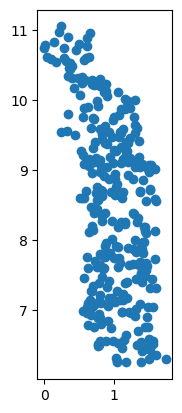

In [11]:
togo_eval_gdf.plot()

In [12]:
brazil_eval = cropharvest_df[(cropharvest_df.dataset == "lem-brazil") & (cropharvest_df.is_test == True)].reset_index(drop=True)
brazil_eval

,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry
0,None,None,cerrado,non_crop,0,0,-12.141110,-45.821529,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((-45.82294 -12.14292, -45.82280 -12.1..."
1,None,None,cerrado,non_crop,1,0,-12.145210,-45.821058,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((-45.82389 -12.14325, -45.81760 -12.1..."
2,None,None,pasture,non_crop,2,0,-12.148088,-45.821423,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((-45.82461 -12.14622, -45.81824 -12.1..."
3,None,None,coffee,beverage_spice,3,1,-12.151956,-45.812024,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((-45.81202 -12.14691, -45.81194 -12.1..."
4,None,None,cerrado,non_crop,5,0,-12.161342,-45.803431,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((-45.81700 -12.16195, -45.81648 -12.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,None,None,coffee,beverage_spice,837,1,-12.141656,-45.810124,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,"POLYGON ((-45.81011 -12.13672, -45.81011 -12.1..."
62,None,None,coffee,beverage_spice,838,1,-12.132749,-45.797454,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,"POLYGON ((-45.79744 -12.12782, -45.79744 -12.1..."
63,None,None,coffee,beverage_spice,839,1,-12.131279,-45.808112,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,"POLYGON ((-45.80810 -12.12637, -45.80810 -12.1..."
64,None,None,coffee,beverage_spice,840,1,-12.133754,-45.786685,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,"POLYGON ((-45.78667 -12.12886, -45.78667 -12.1..."


In [37]:
brazil_eval['is_crop'].value_counts()

0    38
1    28
Name: is_crop, dtype: int64

In [13]:
brazil_eval_gdf = gpd.GeoDataFrame(
    brazil_eval, geometry=gpd.points_from_xy(brazil_eval.lon, brazil_eval.lat), crs="EPSG:4326"
)
brazil_eval_gdf

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry
0,None,None,cerrado,non_crop,0,0,-12.141110,-45.821529,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,POINT (-45.82153 -12.14111)
1,None,None,cerrado,non_crop,1,0,-12.145210,-45.821058,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,POINT (-45.82106 -12.14521)
2,None,None,pasture,non_crop,2,0,-12.148088,-45.821423,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,POINT (-45.82142 -12.14809)
3,None,None,coffee,beverage_spice,3,1,-12.151956,-45.812024,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,POINT (-45.81202 -12.15196)
4,None,None,cerrado,non_crop,5,0,-12.161342,-45.803431,lem-brazil,2020-01-30T00:00:00,2020-02-01T00:00:00,False,True,POINT (-45.80343 -12.16134)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,None,None,coffee,beverage_spice,837,1,-12.141656,-45.810124,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,POINT (-45.81012 -12.14166)
62,None,None,coffee,beverage_spice,838,1,-12.132749,-45.797454,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,POINT (-45.79745 -12.13275)
63,None,None,coffee,beverage_spice,839,1,-12.131279,-45.808112,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,POINT (-45.80811 -12.13128)
64,None,None,coffee,beverage_spice,840,1,-12.133754,-45.786685,lem-brazil,2020-09-30T00:00:00,2021-02-01T00:00:00,False,True,POINT (-45.78668 -12.13375)


<AxesSubplot:>

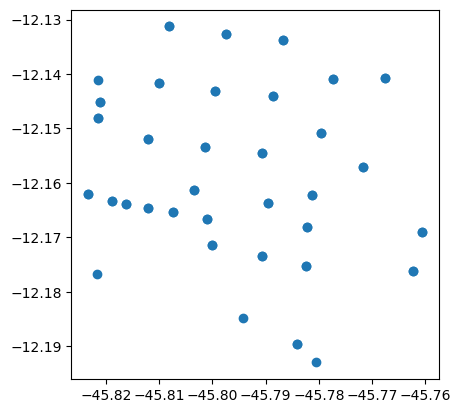

In [14]:
brazil_eval_gdf.plot()

## Kenya labels

In [15]:
DATA_DIR = "../data/cropharvest"

In [16]:
# This will download all geowiki data
evaluation_datasets = CropHarvest.create_benchmark_datasets(DATA_DIR)

In [17]:
evaluation_datasets

[CropHarvestEval(Kenya_1_maize, Kenya_maize),
 CropHarvestEval(Brazil_0_coffee, Brazil_coffee),
 CropHarvestEval(Togo_crop, togo-eval)]

In [18]:
kenya_dataset = evaluation_datasets[0]

In [19]:
kenya_dataset.as_array()[0].shape

(6640, 12, 18)

In [20]:
kenya_dataset.test_data()

<generator object CropHarvest.test_data at 0x7f4a0e3dad50>

In [21]:
cropharvest_labels = CropHarvestLabels(DATA_DIR)
cropharvest_df = cropharvest_labels.as_geojson()
cropharvest_df

,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry
0,None,None,None,None,0,1,10.712596,37.083128,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08252 10.71274, 37.08348 10.71291..."
1,None,None,None,None,1,1,10.724197,37.087377,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08721 10.72398, 37.08714 10.72429..."
2,None,None,None,None,2,1,10.713894,37.085091,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08498 10.71371, 37.08481 10.71393..."
3,None,None,None,None,3,1,10.713338,37.090290,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.09021 10.71320, 37.09014 10.71341..."
4,None,None,None,None,4,1,10.721858,37.083121,ethiopia,2020-10-22T00:00:00,2021-02-01T00:00:00,False,False,"POLYGON ((37.08307 10.72160, 37.08281 10.72197..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95181,None,None,None,None,2395,0,-2.256238,28.550432,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (28.55043 -2.25624)
95182,None,None,None,None,2396,0,-1.260320,37.960356,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (37.96036 -1.26032)
95183,None,None,None,None,2397,0,-6.938295,31.027059,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (31.02706 -6.93830)
95184,None,None,None,None,2398,0,-5.459979,32.016811,tanzania-ceo,2019-01-02T00:00:00,2019-02-01T00:00:00,False,False,POINT (32.01681 -5.45998)


In [22]:
cropharvest_df[cropharvest_df["is_test"] == True].dataset.unique()

array(['togo-eval', 'lem-brazil', 'kenya', 'kenya-non-crop', 'croplands'],
      dtype=object)

In [23]:
kenya_eval = cropharvest_df[(cropharvest_df.dataset == "kenya-non-crop")].reset_index(drop=True)
kenya_eval

,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry
0,None,None,None,None,0,0,0.875058,34.489989,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,False,"POLYGON ((34.48848 0.87856, 34.49180 0.87856, ..."
1,None,None,None,None,1,0,0.846490,34.483464,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,False,"POLYGON ((34.48425 0.84763, 34.48434 0.84763, ..."
2,None,None,None,None,2,0,0.771332,34.548826,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,False,"POLYGON ((34.54891 0.77227, 34.54909 0.77227, ..."
3,None,None,None,None,3,0,0.769495,34.548455,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,False,"POLYGON ((34.54864 0.77019, 34.54873 0.77019, ..."
4,None,None,None,None,4,0,0.725122,34.386282,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,False,"POLYGON ((34.38600 0.72610, 34.38627 0.72610, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,None,None,None,None,2699,0,0.472719,34.229152,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((34.22910 0.47279, 34.22916 0.47281, ..."
2700,None,None,None,None,2700,0,0.475330,34.232335,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((34.23174 0.47638, 34.23206 0.47650, ..."
2701,None,None,None,None,2701,0,0.693609,34.369296,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,False,"POLYGON ((34.36504 0.69521, 34.36530 0.69512, ..."
2702,None,None,None,None,2702,0,0.694983,34.366412,kenya-non-crop,2020-04-16T00:00:00,2020-02-01T00:00:00,False,True,"POLYGON ((34.36639 0.69512, 34.36652 0.69508, ..."


In [24]:
next(iter(kenya_dataset.test_data()))

('Kenya_maize_2020_0_0',
 TestInstance(x=array([[[ 0.16541818,  1.06613983, -0.08701396, ...,  1.01072137,
          -0.3890116 , -0.06625082],
         [ 0.88558946,  1.16850074, -0.16909877, ...,  1.01072137,
          -0.3890116 ,  0.30877612],
         [ 0.71497868,  0.74348949, -0.17045554, ...,  1.01072137,
          -0.3890116 ,  0.27099213],
         ...,
         [ 0.78494456,  1.51140933,  0.03984438, ...,  1.01072137,
          -0.3890116 ,  0.21283316],
         [ 1.32786236,  0.68343071,  2.05126143, ...,  1.01072137,
          -0.3890116 , -1.10664459],
         [ 1.40622403,  1.30089506, -0.27221357, ...,  1.01072137,
          -0.3890116 ,  0.36592963]],
 
        [[ 0.15562811,  0.69415496,  0.10768307, ...,  1.00916949,
          -0.3890116 , -0.13334871],
         [ 0.56881928,  0.70444832, -0.47165931, ...,  1.00916949,
          -0.3890116 ,  0.79432581],
         [ 0.77829012,  0.77053625, -0.0592001 , ...,  1.00916949,
          -0.3890116 ,  0.13152432],
       

In [25]:
for test_id, test_instance in kenya_dataset.test_data():
    print(dir(test_instance))
    #print(test_instance.datasets)

    # preds = model.predict_proba(test_instance.x)[:, 1]

    # results = test_instance.evaluate_predictions(preds)
    print(test_id)
    print(test_instance.datasets['x'].shape)
    print(test_instance.datasets['y'].shape)
    print(test_instance.datasets['lats'].shape)
    print(test_instance.datasets['lons'].shape)

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'datasets', 'evaluate_predictions', 'lats', 'load_from_h5', 'load_from_nc', 'lons', 'to_xarray', 'x', 'y']
Kenya_maize_2020_0_0
(7600, 12, 18)
(7600,)
(7600,)
(7600,)
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__

## 1. Validation points

Transform points to feature collection

In [26]:
## Uncomment and run once
#ee.Authenticate()

In [27]:
ee.Initialize()

In [28]:
val_points = {}
val_points['togo'] = geemap.geopandas_to_ee(togo_eval_gdf)
val_points['brazil'] = geemap.geopandas_to_ee(brazil_eval_gdf)
val_points

{'togo': <ee.featurecollection.FeatureCollection at 0x7f4a18868990>,
 'brazil': <ee.featurecollection.FeatureCollection at 0x7f4a18816090>}

## 2. Landcover products


- ESA WorldCover
- ESRI 2020
- Dynamic world

In [29]:
# Definitions and helper functions

results = {}
nigeria_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))
togo_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Togo'))
brazil_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
true_column = 'is_crop'

# Helper functions
def get_metrics(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print('RF roc-auc test set:', round(roc_auc, 3))
    print('RF precision test set:', round(precision, 3))
    print('RF recall test set:', round(recall, 3))
    print('RF f1-score test set:', round(f1, 3))
    print('RF accuracy test set:', round(acc, 3))
    print('RF confusion matrix:', cm.tolist())

    return {'roc_auc': roc_auc, 'precision': precision, 'recall': recall,
            'f1': f1, 'acc': acc, 'confusion': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}}

def plot_confusion_matrix(tn: int, fp: int, fn: int, tp: int, title: str, save_fig: bool=False) -> ConfusionMatrixDisplay: 
    print(tn, fp, fn, tp)
    cm = np.array([[tn, fp], [fn, tp]])
    cm_display = ConfusionMatrixDisplay(cm)

    fig, ax = plt.subplots(1, 1)
    cm_display.plot(ax=ax)
    labels = ['non-cropland', 'cropland']
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=90)
    fig.suptitle(f'Confusion matrix {title}')

    return cm_display

class NumpyEncoder(json.JSONEncoder):
# https://bobbyhadz.com/blog/python-typeerror-object-of-type-int64-is-not-json-serializable#:~:text=The%20Python%20%22TypeError%3A%20Object%20of,%2C%20e.g.%20int(my_numpy_int)%20.
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

### 2.1 ESA WorldCover

Access [ESA Global Land Cover](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100) landcover product via the GEE catalog.

In [30]:
def evaluate_ESA(val_points):
    map_name = 'ESA'
    esa = ee.ImageCollection("ESA/WorldCover/v100") #.first()
    esa_image = esa.first()
    esa_image_info = esa_image.getInfo()
    class_name = 'Cropland'
    esa_cropland_index = esa_image_info['properties']['Map_class_names'].index(class_name)
    cropland_value = esa_cropland_value = esa_image_info['properties']['Map_class_values'][esa_cropland_index]
    pred_column = f'{map_name}pixel_value'
    results_val_points = esa_image.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median()})
    results_val_gdf = geemap.ee_to_geopandas(results_val_points)
    results_val_gdf.rename(columns={'median': pred_column}, inplace=True)
    results_val_gdf[pred_column].value_counts()
    y_true = results_val_gdf[true_column].to_numpy()
    y_pred = (results_val_gdf[pred_column] == cropland_value).astype(int).to_numpy()
    results = get_metrics(y_true, y_pred)
    assert(len(results_val_gdf) == sum(results['confusion'].values()))
    return results


### 2.2 ESRI 2020

Access [ESRI 2020 Global Land Cover](https://samapriya.github.io/awesome-gee-community-datasets/projects/esrilc2020/) landcover product via a community added public asset in GEE catalog.

In [31]:
def evaluate_ESRI(val_points):
    map_name = 'ESRI'
    esri = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m")
    esri_info = esri.getInfo()
    esri_image = esri.mosaic()
    esri_image.getInfo()
    pred_column = f'{map_name}_pixel_value'
    results_val_points = esri_image.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median(), 'scale': 10}) # need to specify a scale for GEE not to complain
    results_val_gdf = geemap.ee_to_geopandas(results_val_points)# rewrites previous gdf
    results_val_gdf.rename(columns={'median': pred_column}, inplace=True)
    cropland_value = esri_cropland_value = 5 
    y_true = results_val_gdf[true_column].to_numpy()
    y_pred = (results_val_gdf[pred_column] == cropland_value).astype(int).to_numpy()
    results = get_metrics(y_true, y_pred)
    assert(len(results_val_gdf) == sum(results['confusion'].values()))
    return results

### 2.3 Dynamic World

Access [Dynamic World Land Cover](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1?hl=en) landcover product via the GEE catalog.

In [32]:
def evaluate_DW(val_points, boundaries):
    map_name = 'DW'
    start_date = '2020-01-01'
    end_date = '2021-01-01'
    dw_class = geemap.dynamic_world(boundaries, start_date, end_date, return_type='class')

    pred_column = f'{map_name}_pixel_value'
    results_val_points = dw_class.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median(), 'scale': 10}) # need to specify a scale for GEE not to complain
    results_val_gdf = geemap.ee_to_geopandas(results_val_points)# rewrites previous gdf
    results_val_gdf.rename(columns={'median': pred_column}, inplace=True)

    cropland_value = dw_cropland_value = 5 
    y_true = results_val_gdf[true_column].to_numpy()
    y_pred = (results_val_gdf[pred_column] == cropland_value).astype(int).to_numpy()
    results = get_metrics(y_true, y_pred)
    assert(len(results_val_gdf) == sum(results['confusion'].values()))
    return results

In [33]:
results_togo = {}
results_togo['ESA'] = evaluate_ESA(val_points['togo'])
results_togo['ESRI'] = evaluate_ESRI(val_points['togo'])
results_togo['DW'] = evaluate_DW(val_points['togo'], togo_boundaries)
results_togo


RF roc-auc test set: 0.744
RF precision test set: 0.875
RF recall test set: 0.528
RF f1-score test set: 0.659
RF accuracy test set: 0.81
RF confusion matrix: [[192, 8], [50, 56]]
RF roc-auc test set: 0.523
RF precision test set: 0.636
RF recall test set: 0.066
RF f1-score test set: 0.12
RF accuracy test set: 0.663
RF confusion matrix: [[196, 4], [99, 7]]
RF roc-auc test set: 0.752
RF precision test set: 0.609
RF recall test set: 0.764
RF f1-score test set: 0.678
RF accuracy test set: 0.748
RF confusion matrix: [[148, 52], [25, 81]]


{'ESA': {'roc_auc': 0.7441509433962263,
  'precision': 0.875,
  'recall': 0.5283018867924528,
  'f1': 0.6588235294117648,
  'acc': 0.8104575163398693,
  'confusion': {'tn': 192, 'fp': 8, 'fn': 50, 'tp': 56}},
 'ESRI': {'roc_auc': 0.5230188679245283,
  'precision': 0.6363636363636364,
  'recall': 0.0660377358490566,
  'f1': 0.11965811965811965,
  'acc': 0.6633986928104575,
  'confusion': {'tn': 196, 'fp': 4, 'fn': 99, 'tp': 7}},
 'DW': {'roc_auc': 0.7520754716981132,
  'precision': 0.6090225563909775,
  'recall': 0.7641509433962265,
  'f1': 0.6778242677824268,
  'acc': 0.7483660130718954,
  'confusion': {'tn': 148, 'fp': 52, 'fn': 25, 'tp': 81}}}

In [34]:
results_brazil = {}
results_brazil['ESA'] = evaluate_ESA(val_points['brazil'])
results_brazil['ESRI'] = evaluate_ESRI(val_points['brazil'])
results_brazil['DW'] = evaluate_DW(val_points['brazil'], brazil_boundaries)
results_brazil


RF roc-auc test set: 0.573
RF precision test set: 0.556
RF recall test set: 0.357
RF f1-score test set: 0.435
RF accuracy test set: 0.606
RF confusion matrix: [[30, 8], [18, 10]]
RF roc-auc test set: 0.855
RF precision test set: 0.718
RF recall test set: 1.0
RF f1-score test set: 0.836
RF accuracy test set: 0.833
RF confusion matrix: [[27, 11], [0, 28]]
RF roc-auc test set: 0.487
RF precision test set: 0.0
RF recall test set: 0.0
RF f1-score test set: 0.0
RF accuracy test set: 0.561
RF confusion matrix: [[37, 1], [28, 0]]


{'ESA': {'roc_auc': 0.5733082706766917,
  'precision': 0.5555555555555556,
  'recall': 0.35714285714285715,
  'f1': 0.43478260869565216,
  'acc': 0.6060606060606061,
  'confusion': {'tn': 30, 'fp': 8, 'fn': 18, 'tp': 10}},
 'ESRI': {'roc_auc': 0.8552631578947368,
  'precision': 0.717948717948718,
  'recall': 1.0,
  'f1': 0.835820895522388,
  'acc': 0.8333333333333334,
  'confusion': {'tn': 27, 'fp': 11, 'fn': 0, 'tp': 28}},
 'DW': {'roc_auc': 0.4868421052631579,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'acc': 0.5606060606060606,
  'confusion': {'tn': 37, 'fp': 1, 'fn': 28, 'tp': 0}}}

In [35]:
rel_results_path = Path('../results')
rel_results_path.mkdir(parents=True, exist_ok=True)

with (rel_results_path / f'landcovermaps_togo_cropharvest.json').open('w') as f:
    json.dump(results_togo, f, cls=NumpyEncoder)

In [36]:
rel_results_path = Path('../results')
rel_results_path.mkdir(parents=True, exist_ok=True)

with (rel_results_path / f'landcovermaps_brazil_cropharvest.json').open('w') as f:
    json.dump(results_brazil, f, cls=NumpyEncoder)